##1. Introduction

A company aims to forecast product demand in order to optimize inventory management, reduce stockouts, and minimize operational costs.

Demand forecasting is a critical task in inventory management and operational planning. Accurate demand estimates help reduce logistics costs, optimize inventory levels, and improve customer service performance.

In this project, a linear regression model is implemented as a baseline approach to predict product demand, leveraging pricing information, promotional variables, and time-related features.

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##2. Dataset Loading

In [60]:
df = pd.read_csv("dataset_prediccion_demanda.csv")
df.head()


,date,price,promotion,demand
0,2022-01-01,10.745071,0,18
1,2022-01-02,9.792604,1,28
2,2022-01-03,10.971533,0,22
3,2022-01-04,12.284545,0,12
4,2022-01-05,9.648770,0,23


##3. Exploratory Data Analysis (EDA)


In [61]:
df.describe()

,price,promotion,demand
count,730.000000,730.000000,730.000000
mean,9.978949,0.302740,22.700000
std,1.476018,0.459759,10.615703
min,5.138099,0.000000,-10.000000
25%,8.952968,0.000000,15.000000
50%,9.984835,0.000000,23.000000
75%,10.941514,1.000000,31.000000
max,15.779097,1.000000,52.000000


Dataset Description

The dataset consists of a total of 730 records. Since demand is the variable of interest, it shows an average of approximately 23 daily units sold over a two-year period (2022–2023), with a demand variability of around 11 units.

The minimum observed demand is –10 units, which may be attributed to product returns, while the maximum demand reaches 52 units in a single day.

In [62]:
dem_neg=df[df['demand']<0]
dem_neg

,date,price,promotion,demand
245,2022-09-03,9.498248,0,-2
252,2022-09-10,13.183234,0,-4
282,2022-10-10,12.379025,0,-5
297,2022-10-25,10.460949,0,-5
631,2023-09-24,12.294325,0,-1
632,2023-09-25,9.762988,0,-2
641,2023-10-04,12.503532,0,-5
677,2023-11-09,12.628406,0,-10


In [63]:
print(dem_neg.shape)

(8, 4)


Negative Values Analysis

First, the negative demand values are analyzed in detail. A total of 8 negative observations are identified over time, which appear to correspond to product returns. Therefore, it is decided to retain these records in the dataset.

If these observations were instead considered data errors, they could be removed, as they represent approximately 1% of the dataset.

In [64]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       730 non-null    object 
 1   price      730 non-null    float64
 2   promotion  730 non-null    int64  
 3   demand     730 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 22.9+ KB


Data Types Inspection

When inspecting the dataset, we observe that among the available variables, the date feature is stored as an object data type. This variable can be converted to a datetime format in order to enable more effective time-based analysis and feature engineering.

In [65]:
df['date'] = pd.to_datetime(df['date'])

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       730 non-null    datetime64[ns]
 1   price      730 non-null    float64       
 2   promotion  730 non-null    int64         
 3   demand     730 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 22.9 KB


Data Type Updated

In [67]:
df=df.sort_values('date', ascending=True)

Data Ordering Validation

Although the dataset appears to be ordered, this code is used to verify and ensure that the records are properly sorted.

In [68]:
df.isna().sum()

,0
date,0
price,0
promotion,0
demand,0


Missing Values Check

Next, a visual analysis is performed to examine the relationship between the target variable (demand) and each of the other three explanatory variables individually, given the small number of predictors.

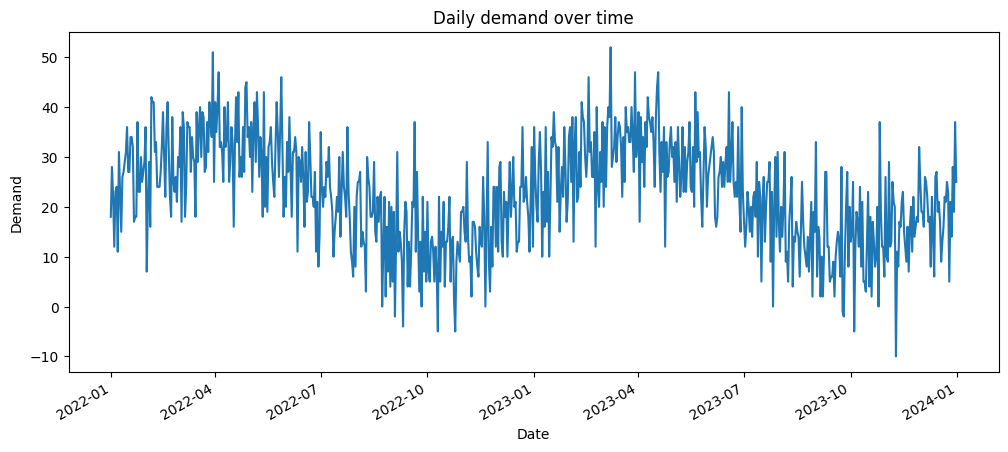

In [69]:
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['demand'])
plt.title('Daily demand over time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.gcf().autofmt_xdate()
plt.show()

Seasonality Insight

Demand exhibits a clear seasonal pattern, suggesting that temporal features will play an important role in the modeling process.

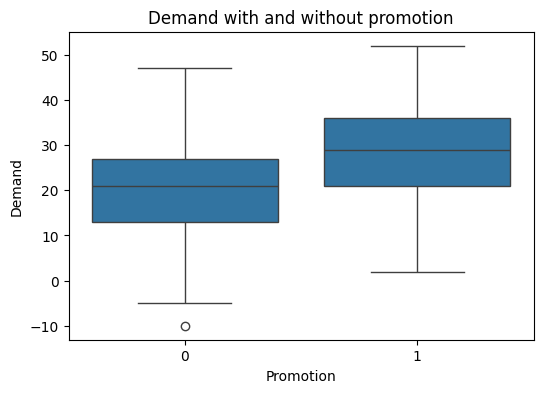

In [70]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='promotion', y='demand', data=df)
plt.title('Demand with and without promotion')
plt.xlabel('Promotion')
plt.ylabel('Demand')
plt.show()

Promotion Effect

It is observed that periods with promotions exhibit a significantly higher demand, indicating that this variable is a relevant predictor for the model.

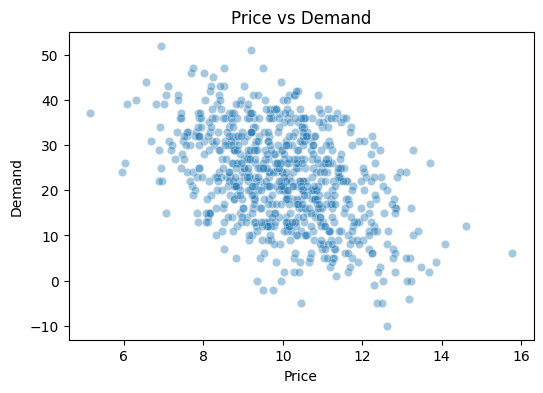

In [71]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='price', y='demand', data=df, alpha=0.4)
plt.title('Price vs Demand')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.show()

Price–Demand Relationship

An inverse relationship between price and demand is observed, which is consistent with the economic theory of price–demand elasticity.

##4. Feature Engineering

In [72]:
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

Temporal Variables

Temporal features are extracted from the date variable in order to capture weekly and monthly patterns in demand.

In [73]:
df['lag_demand_1'] = df['demand'].shift(1)

Lagged Demand

A lagged demand variable (1-day lag) is incorporated to capture temporal dependencies and historical consumption behavior. This feature uses the previous day’s demand as an explanatory variable to predict the current day’s demand.

In [74]:
df.head()

,date,price,promotion,demand,day_of_week,month,lag_demand_1
0,2022-01-01,10.745071,0,18,5,1,NaN
1,2022-01-02,9.792604,1,28,6,1,18.0
2,2022-01-03,10.971533,0,22,0,1,28.0
3,2022-01-04,12.284545,0,12,1,1,22.0
4,2022-01-05,9.648770,0,23,2,1,12.0


The lagged demand feature introduces a null value in the first observation.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          730 non-null    datetime64[ns]
 1   price         730 non-null    float64       
 2   promotion     730 non-null    int64         
 3   demand        730 non-null    int64         
 4   day_of_week   730 non-null    int32         
 5   month         730 non-null    int32         
 6   lag_demand_1  729 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2)
memory usage: 34.3 KB


In [76]:
df.isna().sum()

,0
date,0
price,0
promotion,0
demand,0
day_of_week,0
month,0
lag_demand_1,1


In [77]:
df = df.dropna().reset_index(drop=True)

Observations containing null values generated by the creation of lagged features are removed from the dataset.

In [78]:
df.head()

,date,price,promotion,demand,day_of_week,month,lag_demand_1
0,2022-01-02,9.792604,1,28,6,1,18.0
1,2022-01-03,10.971533,0,22,0,1,28.0
2,2022-01-04,12.284545,0,12,1,1,22.0
3,2022-01-05,9.648770,0,23,2,1,12.0
4,2022-01-06,9.648795,0,24,3,1,23.0


In [79]:
features = [
    'price',
    'promotion',
    'day_of_week',
    'month',
    'lag_demand_1'
]

X = df[features]
y = df['demand']

X.head()

,price,promotion,day_of_week,month,lag_demand_1
0,9.792604,1,6,1,18.0
1,10.971533,0,0,1,28.0
2,12.284545,0,1,1,22.0
3,9.648770,0,2,1,12.0
4,9.648795,0,3,1,23.0


Final Feature Selection

The final set of explanatory variables selected for model training is defined based on the previous exploratory analysis and feature engineering steps.

##5. Data Preparation (Temporal Approach)

In [80]:
split_date = df['date'].quantile(0.8)

train_df = df[df['date'] <= split_date]
test_df  = df[df['date'] > split_date]

X_train = train_df[features]
y_train = train_df['demand']

X_test = test_df[features]
y_test = test_df['demand']

Temporal Train–Test Split

The data is split while preserving the temporal order to simulate a real-world future prediction scenario and to prevent data leakage.

In [81]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Feature Scaling

Standardization is applied to the predictor variables using only the training set, thereby preventing data leakage.

In [82]:
X_train_scaled.mean(axis=0)

array([ 1.16392506e-15, -3.04692425e-18,  1.25685625e-17, -1.40158516e-16,
       -1.34064667e-16])

Scaling Validation

A validation step is performed to confirm that the scaling was applied correctly by verifying that the training set features have a mean close to zero.

##6. Baseline Model: Linear Regression

In [83]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

A linear regression model is trained as a baseline approach for demand prediction.

In [84]:
y_pred = lin_reg.predict(X_test_scaled)

The model generates predictions on future data not seen during training.

In [85]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2

(4.859090862494554, np.float64(6.214780031571652), 0.430803112812275)

Model Evaluation Metrics

The MAE represents the average error in demand units and is approximately 5 units, while the RMSE, which penalizes larger errors, suggests that the model tends to perform worse in extreme scenarios, as it is higher than the MAE.

These metrics are generally more informative than R² in an operational context. However, the R² value indicates that the model explains approximately 43% of the variability in demand.

In [86]:
coef_df = pd.DataFrame({
    'Variable': features,
    'Coeficiente': lin_reg.coef_
}).sort_values(by='Coeficiente', ascending=False)

coef_df

,Variable,Coeficiente
1,promotion,3.750861
4,lag_demand_1,2.859600
2,day_of_week,0.101019
3,month,-3.577923
0,price,-4.680611


Model Coefficients Interpretation

The coefficients represent the expected change in demand associated with a one standard deviation change in each variable, while holding all other variables constant.

Promotion: When a promotion is active, demand increases significantly, showing a strong positive impact.

Lagged Demand (lag_demand_1): If the previous day’s demand increases by one standard deviation, the current day’s demand increases by an average of 2.86 units.

Day of Week: This variable has a smaller effect on demand compared to other predictors.

Month: Certain months exhibit notably lower or higher sales levels, reflecting seasonal effects.

Price: This variable shows an inverse relationship with demand, where higher prices lead to lower demand.

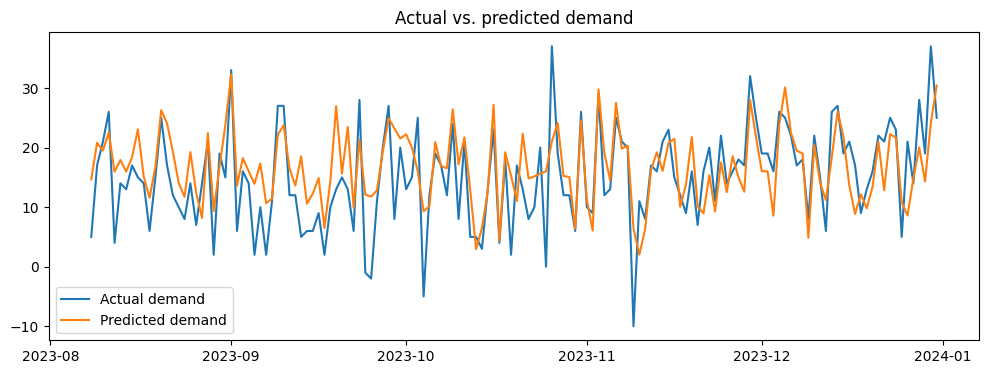

In [87]:
plt.figure(figsize=(12, 4))
plt.plot(test_df['date'], y_test.values, label='Actual demand')
plt.plot(test_df['date'], y_pred, label='Predicted demand')
plt.legend()
plt.title('Actual vs. predicted demand')
plt.show()

The model adequately captures the overall demand trend, although it shows limitations in modeling abrupt demand spikes, which is expected for a baseline linear model.

##Conclusions

-The linear regression model performs adequately as a baseline model for demand forecasting, capturing the overall trend and seasonality.

-Promotions have the largest marginal impact on demand when active, while lagged demand explains the continuity and stability of consumption over time.

-Demand shows a strong temporal dependence.

-Price exhibits an inverse relationship with demand, consistent with the economic theory of price–demand elasticity.

-Metrics such as MAE and RMSE are more useful than R² in an operational context, as they are directly interpretable in product units.

## Limitations

Linear regression does not capture non-linear relationships or abrupt demand spikes.

The analysis does not consider multiple products or cross-product effects.

The model assumes linear relationships that remain constant over time.

## Next Steps

Implement regularization models such as Ridge and Lasso to improve model stability.

Evaluate more advanced models such as Random Forest, XGBoost, or time series models (ARIMA, Prophet).

Incorporate additional business variables, such as weather data, holidays, or multiple products.

Validate model performance using temporal cross-validation.